# SIMEX notebook for wavefront propagation using the SimEx Calculator "WavePropagator".

In this notebook, we will demonstrate how to simulate diffraction of coherent radiation on a thin wire.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

initializing ocelot...


### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`. Looking up the documentation of these two classes gives us the information needed to create the instances:

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [3]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = 1*meter
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [55]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [56]:
photon_source.backengine()

We can retrieve the wavefront data from the calculator:

In [57]:
wavefront = photon_source.data

Let's visualize the wavefront using the WPG utilities.

In [30]:
from wpg import wpg_uti_wf as wpg_utils

First plot the intensity distribution

R-space
(400,) (400,)
FWHM in x = 1.019e-04 m.
FWHM in y = 1.019e-04 m.


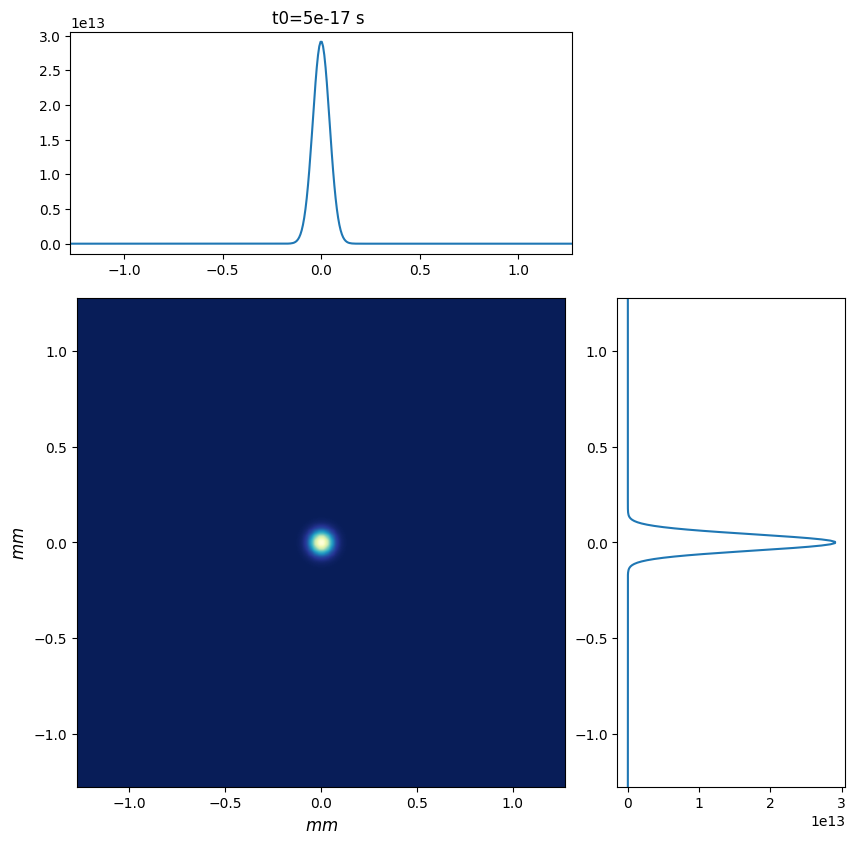

In [31]:
wpg_utils.plot_intensity_map(wavefront)

## Plot intensity distribution in q-space

Q-space
{'fwhm_x': 6.657123479604694e-07, 'fwhm_y': 6.657123479604694e-07}
Q-space
(400,) (400,)


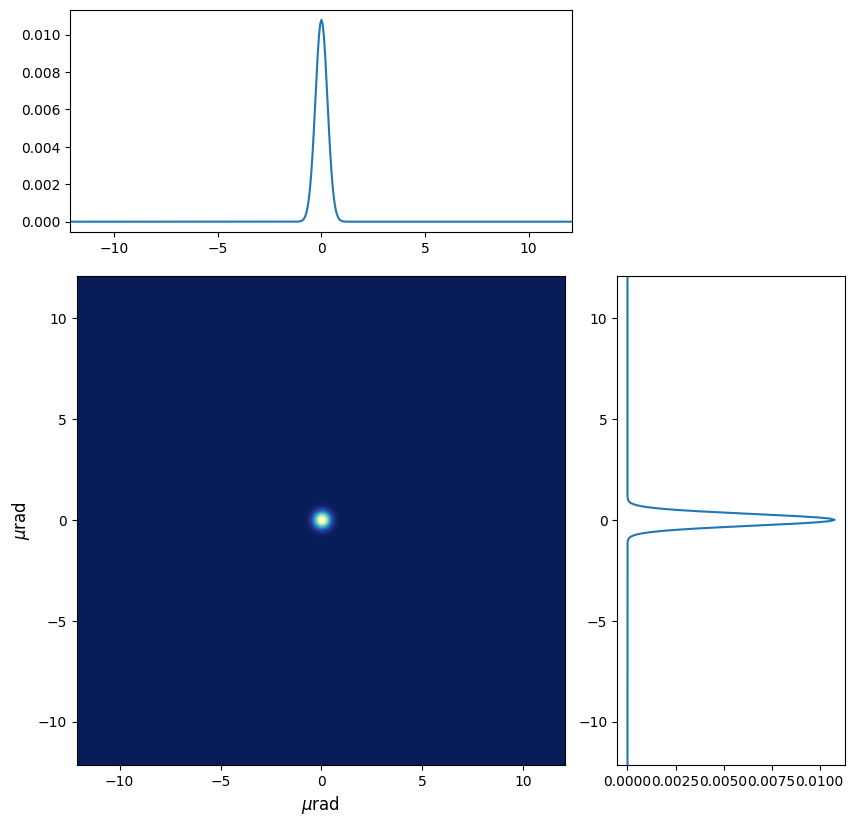

In [9]:
wpg_utils.plot_intensity_qmap(wavefront)

Plot the power as a function of time integrated over the transverse dimensions

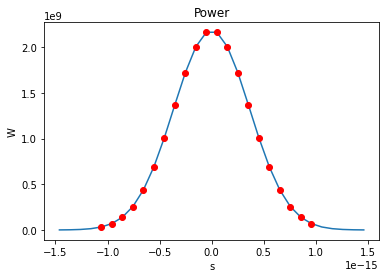

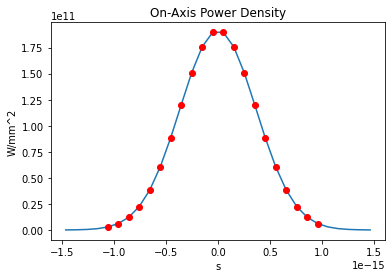

number of meaningful slices: 21
Pulse energy 2e-06 J


940677412.5714285

In [10]:
wpg_utils.integral_intensity(wavefront)

Plot the power spectrum

In [11]:
import wpg

Check the sampling quality

In [12]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.019e-04|6.386e-06|2.548e-03|1.462e+02|1.111e-04|4.470e-05|6.386e-05|
|Vertical  |1.019e-04|6.386e-06|2.548e-03|1.462e+02|1.111e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


Ok, we're happy with our initial wavefront and will now proceed to setup the beamline. Our beamline will consist just of a stretch of vacuum over 10 m distance.

For numerical reasons, we have to set the radius of curvature to a finite value. Here we choose to set it to a value corresponding approximately to a distance of 1 m from the source position, $z = 1\,\mathrm{m}$.

The radius of curvature $R_{cur}(z)=z\left[{1+{\left({\frac {R}{z}}\right)}^{2}}\right]$

In [16]:
wavefront.params.Rx = wavefront.params.Ry = 150**2 

## Setup the beamline
Our experiment consists of
* The photon source at the origin
* 100 m of free space
* The diffraction object 
* Another distance of free space
* The detector (screen)

In [17]:
from wpg import Beamline, optical_elements, srwlib
from wpg.useful_code.wfrutils import propagate_wavefront

In [58]:
beamline = Beamline()

In [59]:
free_space = optical_elements.Drift(_L=100, _treat=1)

In [60]:
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

In [61]:
beamline.append(free_space, free_space_propagation_parameters)

In [62]:
wire = optical_elements.Aperture?

Signature: optical_elements.Aperture(shape, ap_or_ob, Dx, Dy=1e+23, x=0, y=0)
Docstring:
Defining an aperture/obstacle propagator: A wrapper to a SRWL function SRWLOptA()

:param shape:    'r' for rectangular, 'c' for circular
:param ap_or_ob:  'a' for aperture, 'o' for obstacle
:param Dx, Dy:   transverse dimensions [m]; in case of circular aperture, only Dx is used for diameter
:param x, y:     transverse coordinates of center [m]
:return: opAp  - aperture propagator, ``struct SRWLOptA``
File:      ~/Projects/dot.conda/envs/simex/lib/python3.7/wpg/optical_elements.py
Type:      function


In [ ]:
wire = optical_elements.Aperture

In [63]:
wire = optical_elements.Aperture

In [64]:
wire = optical_elements.Aperture(
    shape='r',
    ap_or_ob='o',
    Dx=1.0,
    Dy=1.0e-4,
    x=0.0,
    y=0.0,
)

In [65]:
wire_pp = optical_elements.Use_PP(semi_analytical_treatment=0)

In [66]:
beamline.append(wire, wire_pp)

In [67]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront,beamline)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 100
	treat = 1
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 1.0
	Dy = 0.0001
	ap_or_ob = o
	shape = r
	x = 0.0
	y = 0.0
	

R-space
nx   400  range_x [-1.3e+00, 1.3e+00] mm
ny   400  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
done


R-space
(400,) (400,)
FWHM in x = 0.000e+00 m.
FWHM in y = 6.436e-05 m.


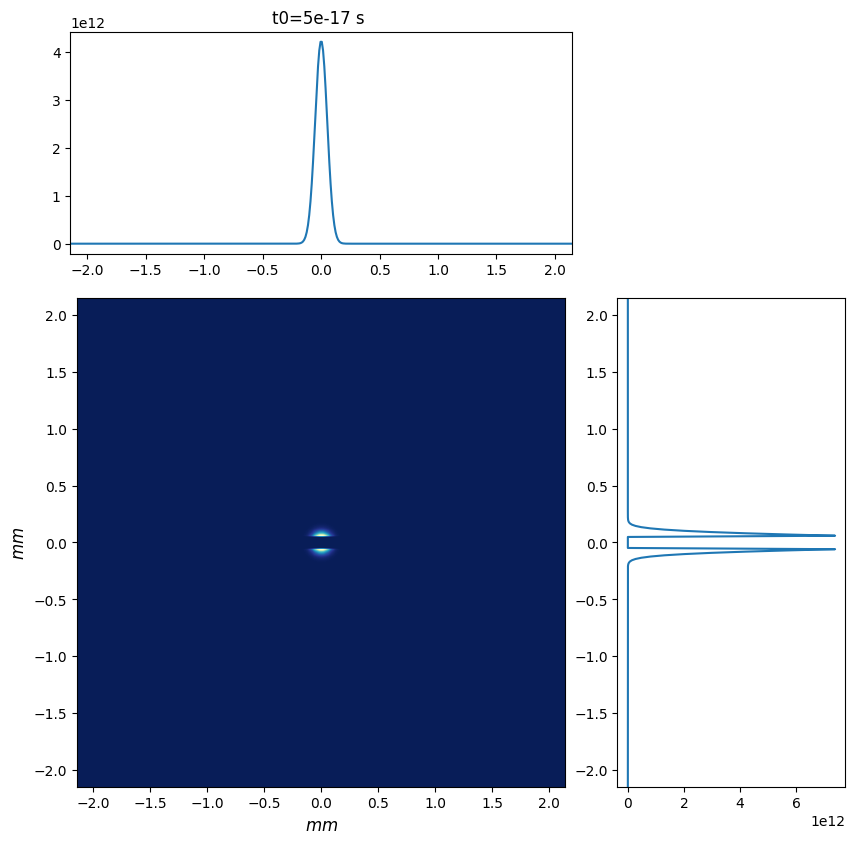

In [68]:
wpg_utils.plot_intensity_map(wavefront)

Immediately after the slit, the intensity distribution is characterized by a sharply distinguished shadow are that goes right through the center of the intensity distribution. In the x-direction, the distribution is identical to the situation before the wire.

What intensity distribution do we expect further downstream from the wire?

In [74]:
# Propagate for another 100 m

In [69]:
wire_to_screen = optical_elements.Drift(_L=100, _treat=1)

In [70]:
wire_to_screen_pp = optical_elements.Use_PP(semi_analytical_treatment=1)

In [71]:
wire_to_screen_bl = Beamline()
wire_to_screen_bl.append(wire_to_screen, wire_to_screen_pp)

In [72]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront, wire_to_screen_bl)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 100
	treat = 1
	

R-space
nx   400  range_x [-2.1e+00, 2.1e+00] mm
ny   400  range_y [-2.1e+00, 2.1e+00] mm
*****propagating wavefront (with resizing)...
done


R-space
(400,) (400,)
FWHM in x = 1.735e-04 m.
FWHM in y = 2.162e-04 m.


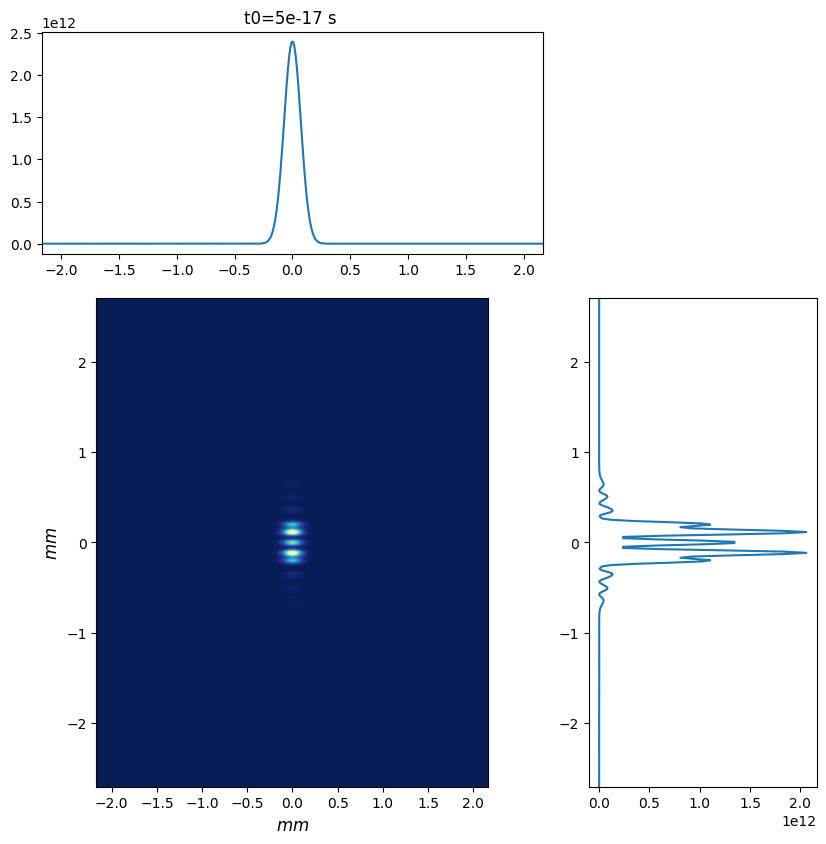

In [73]:
wpg_utils.plot_intensity_map(wavefront)

After another 100 m of propagation through free space, the intensity distribution is basically undisturbed in the projection on the x-axis, whereas we observe a
distinct diffraction pattern in the vertical direction (y-axis projection). Both edges of the wire cause diffraction side maxima and the overlapping side maxima in the center (in the shade area of the wire) produce a strong diffraction peak.

**Tasks**
1. Configure another diffraction experiment where, instead of a wire, you position a thin slit 100 m away from the source.
1. Observe the intensity distribution 100 m away from the slit.
1. Compare to the result above for the wire
1. Discuss your findings. Recall *Babinet's principle*.